In [1]:
import json
import math
import re
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from tqdm.auto import tqdm


In [2]:
ARTIFACT_DIR = Path('artifacts')
ARTIFACT_DIR.mkdir(exist_ok=True)
LOG_FILE = ARTIFACT_DIR / 'training.log'
LOG_FILE.touch(exist_ok=True)

def log_message(message):
    timestamp = pd.Timestamp.utcnow().isoformat()
    line = f'[{timestamp}] {message}'
    print(line)
    with open(LOG_FILE, 'a') as fh:
        fh.write(line + '\n')


In [3]:
def calculate_sharpe(pnl_series):
    std = pnl_series.std()
    if std == 0:
        return 0.0
    return pnl_series.mean() / std


## Load data

In [4]:

DATA_PATH = Path('../autodl-tmp/final_df.csv')
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Cannot find {DATA_PATH}")

df_ori = pd.read_csv(DATA_PATH)
df = df_ori.copy()
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(['symbol', 'datetime']).reset_index(drop=True)

symbol_list = sorted(df['symbol'].unique())
symbol_to_id = {sym: idx for idx, sym in enumerate(symbol_list)}
df['symbol_id'] = df['symbol'].map(symbol_to_id).astype(np.int64)
NUM_SYMBOLS = len(symbol_list)
print(f"Loaded {NUM_SYMBOLS} symbols: {symbol_list}")

df['lret_1m'] = df.groupby('symbol')['close'].transform(lambda s: np.log(s).diff())
df['y_target'] = df.groupby('symbol')['lret_1m'].shift(-1)

initial_rows = len(df)
df = df[df['y_target'].abs() <= 0.2].dropna(subset=['y_target', 'lret_1m'])
df = df.sort_values(['datetime', 'symbol']).reset_index(drop=True)
print(f"Dropped {initial_rows - len(df)} rows with abnormal/NaN targets")
print(df[['datetime', 'symbol', 'close', 'lret_1m', 'y_target']].head())


Loaded 5 symbols: ['AMAT', 'AMD', 'AVGO', 'MU', 'NVDA']
Dropped 12 rows with abnormal/NaN targets
             datetime symbol      close   lret_1m  y_target
0 2024-04-30 12:51:00   AMAT  200.51000 -0.000199 -0.000100
1 2024-04-30 12:51:00    AMD  159.36000  0.000314 -0.000126
2 2024-04-30 12:51:00   AVGO  131.65200 -0.000334  0.000721
3 2024-04-30 12:51:00     MU  114.58000  0.000698 -0.000698
4 2024-04-30 12:51:00   NVDA   86.89927 -0.000769 -0.000907


In [5]:
# print the length of the dataframe
print(f"Dataframe length: {len(df)}")

Dataframe length: 324888


In [6]:
# 统计每个日期有多少不同的分钟时间点（按分钟去重）
minutes_per_day = (
    df.assign(minute = df['datetime'].dt.floor('min'))
      .groupby(df['datetime'].dt.date)['minute']
      .nunique()
      .sort_index()
)

print("每个日期的不同分钟数（按分钟聚合）:")
print(minutes_per_day)

print("\n汇总统计:")
print(minutes_per_day.describe())

每个日期的不同分钟数（按分钟聚合）:
datetime
2024-04-30    189
2024-05-01    190
2024-05-02    190
2024-05-03    190
2024-05-06    190
             ... 
2025-10-22    190
2025-10-23    190
2025-10-24    190
2025-10-27    190
2025-10-28    189
Name: minute, Length: 342, dtype: int64

汇总统计:
count    342.000000
mean     189.994152
std        0.076360
min      189.000000
25%      190.000000
50%      190.000000
75%      190.000000
max      190.000000
Name: minute, dtype: float64


## Feature cleaning

In [7]:
y = df['y_target']
X = df.drop(columns=[
    'y_target', 'lret_1m', 'datetime', 'symbol',
    'year', 'month', 'day', 'minute', 'minute_of_day'
], errors='ignore')
print(f"Original feature shape: {X.shape}")

stats = X.describe(percentiles=[0.99]).T
bad_cols = set()
bad_cols.update(stats.index[stats['std'] > 1e3])
bad_cols.update(stats.index[stats['99%'].abs() > 1e3])
bad_cols.update(stats.index[stats['max'].abs() > 1e6])
bad_cols.update(stats.index[stats['std'] == 0])

bad_cols = sorted(bad_cols)
print(f"Dropping {len(bad_cols)} problematic columns")
X_cleaned = X.drop(columns=bad_cols)
print(f"Cleaned feature shape: {X_cleaned.shape}")


Original feature shape: (324888, 185)
Dropping 37 problematic columns
Cleaned feature shape: (324888, 148)


## Train / test split

In [8]:
split_ratio = 1.0 / 1.5
split_index = int(len(X_cleaned) * split_ratio)

X_train = X_cleaned.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X_cleaned.iloc[split_index:]
y_test = y.iloc[split_index:]

print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")


Train shape: (216592, 148)
Test shape:  (108296, 148)


## Preprocessing pipeline

Same as in LASSO, ridge regression notebook

In [9]:

class QuantileClipper(BaseEstimator, TransformerMixin):
    def __init__(self, lower=0.005, upper=0.995):
        self.lower = lower
        self.upper = upper
        self.q_low_ = None
        self.q_high_ = None

    def fit(self, X, y=None):
        self.q_low_ = np.nanpercentile(X, self.lower * 100, axis=0)
        self.q_high_ = np.nanpercentile(X, self.upper * 100, axis=0)
        return self

    def transform(self, X):
        return np.clip(X, self.q_low_, self.q_high_)

def split_columns_for_scaling(X):
    patterns = [
        r'^fz_', r'_z_', r'(?:^|_)tanh', r'(?:^|_)arctanh',
        r'(?:^|_)sin$', r'(?:^|_)cos$', r'^dow_\d+$',
        r'^has_news$', r'(?:^|_)log', r'(?:^|_)ln', r'(?:^|_)ewm',
        r'^tone_', r'_flag$', r'_iqr_outlier$'
    ]
    regex = re.compile('|'.join(patterns))
    name_matched = [c for c in X.columns if regex.search(c)]
    binary_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 2]
    no_scale_cols = sorted(set(name_matched + binary_cols))
    scale_cols = [c for c in X.columns if c not in no_scale_cols]
    return no_scale_cols, scale_cols

no_scale_cols, scale_cols = split_columns_for_scaling(X_cleaned)

raw_branch_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('clip', QuantileClipper(lower=0.005, upper=0.995)),
    ('scale', MaxAbsScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('raw_scaler', raw_branch_pipeline, scale_cols),
        ('passthrough_features', 'passthrough', no_scale_cols),
    ],
    remainder='drop'
)

X_all_processed = preprocessor.fit_transform(X_cleaned)
feature_cols = scale_cols + no_scale_cols
X_all_processed = pd.DataFrame(
    X_all_processed,
    columns=feature_cols,
    index=X_cleaned.index
)

print("Preprocessing complete")


Preprocessing complete


### Feature preprocessing parity
We mirror the LASSO notebook by splitting raw vs. pre-engineered features via regex, applying QuantileClipper + MaxAbsScaler only to the raw branch, and passthrough everything else. A median imputer is kept before clipping so tensor batches never contain NaNs when fed into PyTorch.


In [10]:

df_processed = X_all_processed.copy()
df_processed[['datetime', 'symbol', 'y_target']] = df[['datetime', 'symbol', 'y_target']].values

train_df = df_processed.iloc[:split_index].copy()
test_df = df_processed.iloc[split_index:].copy()


In [11]:
# 输出每列的统计特征
print("训练集每列统计特征:")
print(train_df.describe().T)
print("测试集每列统计特征:")
print(test_df.describe().T)

训练集每列统计特征:
                  count                           mean                  min  \
f_minsin       216592.0                      -0.608936                 -1.0   
f_mincos       216592.0                      -0.797668                 -1.0   
close          216592.0                       0.409318             0.198926   
f_volume_norm  216592.0                       0.017189            -0.171817   
high           216592.0                       0.409439             0.199044   
...                 ...                            ...                  ...   
volu_z_15      216592.0                        0.16572            -2.804441   
volu_z_30      216592.0                       0.245106            -2.965688   
volu_z_5       216592.0                       0.063102             -1.78767   
volu_z_60      216592.0                       0.320376            -3.015014   
datetime         216592  2024-10-28 18:08:50.760046848  2024-04-30 12:51:00   

                               25%      

## Sequence construction

In [12]:

SEQ_LEN = 30
PRED_HORIZON = 1


def build_sequences(dataframe, feature_cols, target_col, seq_len=SEQ_LEN):
    X_seq, y_seq, meta_dt, symbol_ids = [], [], [], []
    for symbol, group in dataframe.groupby('symbol'):
        group = group.sort_values('datetime')
        feats = group[feature_cols].values
        target = group[target_col].values
        dts = group['datetime'].values
        symbol_id = group['symbol_id'].iloc[0]
        for i in range(len(group) - seq_len - PRED_HORIZON + 1):
            start = i
            end = i + seq_len
            target_idx = end + PRED_HORIZON - 1
            X_seq.append(feats[start:end])
            y_seq.append(target[target_idx])
            meta_dt.append(dts[target_idx])
            symbol_ids.append(symbol_id)
    return (
        np.array(X_seq, dtype=np.float32),
        np.array(y_seq, dtype=np.float32),
        np.array(meta_dt),
        np.array(symbol_ids, dtype=np.int64)
    )

train_X_seq, train_y_seq, train_meta_dt, train_symbol_ids = build_sequences(
    train_df, feature_cols, 'y_target', seq_len=SEQ_LEN
)

test_X_seq, test_y_seq, test_meta_dt, test_symbol_ids = build_sequences(
    test_df, feature_cols, 'y_target', seq_len=SEQ_LEN
)

train_y_direction = (train_y_seq > 0).astype(np.float32)
test_y_direction = (test_y_seq > 0).astype(np.float32)

print(f"Train sequences: {train_X_seq.shape}")
print(f"Test sequences:  {test_X_seq.shape}")


Train sequences: (216442, 30, 148)
Test sequences:  (108146, 30, 148)


In [13]:
train_order = np.argsort(train_meta_dt)
train_X_seq = train_X_seq[train_order]
train_y_seq = train_y_seq[train_order]
train_meta_dt = train_meta_dt[train_order]

test_order = np.argsort(test_meta_dt)
test_X_seq = test_X_seq[test_order]
test_y_seq = test_y_seq[test_order]
test_meta_dt = test_meta_dt[test_order]


In [14]:
y_scaler = StandardScaler()
train_y_seq_raw = train_y_seq.copy()
test_y_seq_raw = test_y_seq.copy()

train_y_seq = y_scaler.fit_transform(train_y_seq.reshape(-1, 1)).astype(np.float32).ravel()
test_y_seq = y_scaler.transform(test_y_seq.reshape(-1, 1)).astype(np.float32).ravel()


## Prefix K-fold DataLoaders

In [15]:

BATCH_SIZE = 256
PURGE_GAP_MINUTES = 60
EMBARGO_GAP_MINUTES = 30


def _apply_purge_embargo(train_idx, val_idx, meta_dt, purge_minutes, embargo_minutes):
    train_times = meta_dt[train_idx]
    val_times = meta_dt[val_idx]
    if len(train_times) == 0 or len(val_times) == 0:
        return train_idx, val_idx
    purge_cutoff = train_times.max() + np.timedelta64(purge_minutes, 'm')
    val_mask = val_times > purge_cutoff
    if not val_mask.any():
        val_mask = np.ones_like(val_idx, dtype=bool)
    embargo_cutoff = val_times.min() - np.timedelta64(embargo_minutes, 'm')
    train_mask = train_times < embargo_cutoff
    if not train_mask.any():
        train_mask = np.ones_like(train_idx, dtype=bool)
    return train_idx[train_mask], val_idx[val_mask]


def create_prefix_folds(X_seq, symbol_ids, y_dir_seq, y_ret_seq, meta_dt, n_splits=10,
                        batch_size=BATCH_SIZE, purge_minutes=PURGE_GAP_MINUTES,
                        embargo_minutes=EMBARGO_GAP_MINUTES):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    folds = []
    fold_meta = []
    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X_seq), start=1):
        train_idx_adj, val_idx_adj = _apply_purge_embargo(train_idx, val_idx, meta_dt, purge_minutes, embargo_minutes)
        if len(train_idx_adj) == 0 or len(val_idx_adj) == 0:
            train_idx_adj, val_idx_adj = train_idx, val_idx
        X_tr, X_va = X_seq[train_idx_adj], X_seq[val_idx_adj]
        sym_tr, sym_va = symbol_ids[train_idx_adj], symbol_ids[val_idx_adj]
        ydir_tr, ydir_va = y_dir_seq[train_idx_adj], y_dir_seq[val_idx_adj]
        yret_tr, yret_va = y_ret_seq[train_idx_adj], y_ret_seq[val_idx_adj]

        train_ds = TensorDataset(
            torch.from_numpy(X_tr),
            torch.from_numpy(sym_tr),
            torch.from_numpy(ydir_tr),
            torch.from_numpy(yret_tr)
        )
        val_ds = TensorDataset(
            torch.from_numpy(X_va),
            torch.from_numpy(sym_va),
            torch.from_numpy(ydir_va),
            torch.from_numpy(yret_va)
        )
        folds.append((
            DataLoader(train_ds, batch_size=batch_size, shuffle=True),
            DataLoader(val_ds, batch_size=batch_size, shuffle=False)
        ))
        fold_meta.append({
            'fold': fold_idx,
            'train_end': meta_dt[train_idx_adj].max(),
            'val_end': meta_dt[val_idx_adj].max()
        })
        log_message(f"Fold {fold_idx}: train {len(train_ds)} seq, val {len(val_ds)} seq")
    return folds, fold_meta

prefix_folds, fold_time_meta = create_prefix_folds(
    train_X_seq,
    train_symbol_ids,
    train_y_direction,
    train_y_seq,
    train_meta_dt,
    n_splits=10
)


[2025-11-09T20:21:49.330344+00:00] Fold 1: train 19530 seq, val 19563 seq
[2025-11-09T20:21:49.828444+00:00] Fold 2: train 39205 seq, val 19374 seq
[2025-11-09T20:21:50.506924+00:00] Fold 3: train 58880 seq, val 19375 seq
[2025-11-09T20:21:51.362275+00:00] Fold 4: train 78695 seq, val 19376 seq
[2025-11-09T20:21:52.423506+00:00] Fold 5: train 98235 seq, val 19417 seq
[2025-11-09T20:21:53.617020+00:00] Fold 6: train 117910 seq, val 19373 seq
[2025-11-09T20:21:55.009798+00:00] Fold 7: train 137594 seq, val 19375 seq
[2025-11-09T20:21:56.598771+00:00] Fold 8: train 157264 seq, val 19546 seq
[2025-11-09T20:21:58.336765+00:00] Fold 9: train 176939 seq, val 19372 seq
[2025-11-09T20:22:00.267083+00:00] Fold 10: train 196614 seq, val 19373 seq


In [16]:
# Global experiment / logging config
ARTIFACT_DIR = Path('artifacts')
ARTIFACT_DIR.mkdir(exist_ok=True)
LOG_FILE = ARTIFACT_DIR / 'training.log'
LOG_FILE.touch(exist_ok=True)

CV_SHARPE_THRESHOLD = 0.0
CV_MAX_FOLDS = 6
FINE_TUNE_EPOCHS = 12
FINE_TUNE_PATIENCE = 3
ENSEMBLE_LR = 3e-4
ENSEMBLE_WEIGHT_DECAY = 5e-4
ROLLING_STEP_MINUTES = 30
TOP_K = 5

def log_message(message):
    timestamp = pd.Timestamp.utcnow().isoformat()
    line = f"[{timestamp}] {message}"
    print(line)
    with open(LOG_FILE, 'a') as fh:
        fh.write(line + '\n')


## Transformer model

In [17]:

class ReturnTransformer(nn.Module):
    def __init__(self, feature_dim, num_symbols, emb_dim=4, d_model=96, nhead=4, num_layers=1, ff_dim=256, dropout=0.5):
        super().__init__()
        self.symbol_emb = nn.Embedding(num_symbols, emb_dim)
        self.input_proj = nn.Linear(feature_dim + emb_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Linear(d_model, 1)

    def forward(self, x, symbol_ids):
        emb = self.symbol_emb(symbol_ids)
        emb = emb.unsqueeze(1).expand(-1, x.size(1), -1)
        x = torch.cat([x, emb], dim=-1)
        x = self.input_proj(x)
        encoded = self.encoder(x)
        pooled = encoded[:, -1, :]
        return self.head(self.dropout(pooled)).squeeze(-1)


## Training utilities

In [18]:

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for xb, symb, yb_cls, _ in loader:
        xb = xb.to(DEVICE)
        symb = symb.to(DEVICE)
        yb_cls = yb_cls.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb, symb)
        loss = criterion(logits, yb_cls)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item() * len(xb)
    return total_loss / len(loader.dataset)


def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for xb, symb, yb_cls, _ in loader:
            xb = xb.to(DEVICE)
            symb = symb.to(DEVICE)
            yb_cls = yb_cls.to(DEVICE)
            logits = model(xb, symb)
            loss = criterion(logits, yb_cls)
            total_loss += loss.item() * len(xb)
    return total_loss / len(loader.dataset)


def predict_batches(model, X_array, symbol_ids, batch_size=512):
    model.eval()
    preds = []
    with torch.no_grad():
        for start in range(0, len(X_array), batch_size):
            batch_x = torch.from_numpy(X_array[start:start + batch_size]).to(DEVICE)
            batch_sym = torch.from_numpy(symbol_ids[start:start + batch_size]).to(DEVICE)
            preds.append(model(batch_x, batch_sym).cpu().numpy())
    return np.concatenate(preds)


In [19]:

def compute_direction_metrics(logits, y_returns, y_direction):
    probs = 1.0 / (1.0 + np.exp(-logits))
    pred_sign = np.where(probs >= 0.5, 1.0, -1.0)
    actual_sign = np.where(y_direction >= 0.5, 1.0, -1.0)
    accuracy = (pred_sign == actual_sign).mean()
    pnl = pd.Series(pred_sign * y_returns)
    sharpe = calculate_sharpe(pnl)
    pearson_ic = pd.Series(probs).corr(pd.Series(y_returns))
    spearman_ic = pd.Series(probs).corr(pd.Series(y_returns), method='spearman')
    return {
        'accuracy': float(accuracy),
        'sharpe': float(sharpe),
        'ic_pearson': float(pearson_ic) if pearson_ic is not None else np.nan,
        'ic_spearman': float(spearman_ic) if spearman_ic is not None else np.nan,
        'probs': probs,
        'pred_sign': pred_sign
    }


In [20]:

def evaluate_loader_metrics(model, loader):
    model.eval()
    logits_list, returns_list, dir_list = [], [], []
    with torch.no_grad():
        for xb, symb, yb_cls, yb_ret in loader:
            xb = xb.to(DEVICE)
            symb = symb.to(DEVICE)
            logits = model(xb, symb).cpu().numpy()
            logits_list.append(logits)
            returns_list.append(yb_ret.numpy())
            dir_list.append(yb_cls.numpy())
    logits = np.concatenate(logits_list)
    y_returns = np.concatenate(returns_list)
    y_dir = np.concatenate(dir_list)
    return compute_direction_metrics(logits, y_returns, y_dir)


In [21]:
def evaluate_sharpe(model, loader, scaler):
    model.eval()
    preds_list, rets_list = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            preds = model(xb).cpu().numpy()
            rets = yb.cpu().numpy()
            preds_raw = scaler.inverse_transform(preds.reshape(-1, 1)).ravel()
            rets_raw = scaler.inverse_transform(rets.reshape(-1, 1)).ravel()
            preds_list.append(preds_raw)
            rets_list.append(rets_raw)
    preds = np.concatenate(preds_list)
    rets = np.concatenate(rets_list)
    return calculate_sharpe(pd.Series(preds * rets))


## Prefix CV training

In [22]:
import copy

def fit_with_prefix_cv(
    folds,
    feature_dim,
    num_symbols,
    model_kwargs=None,
    epochs=24,
    lr=3e-4,
    weight_decay=1e-3,
    patience=5,
):
    model_kwargs = model_kwargs or {}
    histories = []
    best_states = []
    criterion = nn.BCEWithLogitsLoss()
    for fold_idx, (train_loader, val_loader) in enumerate(folds, start=1):
        model = ReturnTransformer(feature_dim, num_symbols, **model_kwargs).to(DEVICE)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-5
        )
        best_val = math.inf
        best_sharpe = -math.inf
        best_state = None
        patience_ctr = 0
        fold_curve = []

        for epoch in range(1, epochs + 1):
            train_loss = train_epoch(model, train_loader, optimizer, criterion)
            val_loss = eval_epoch(model, val_loader, criterion)
            val_metrics = evaluate_loader_metrics(model, val_loader)
            fold_curve.append({
                'fold': fold_idx,
                'epoch': epoch,
                'train_loss': float(train_loss),
                'val_loss': float(val_loss),
                'val_sharpe': val_metrics['sharpe'],
                'val_accuracy': val_metrics['accuracy']
            })
            improved = False
            if val_loss < best_val - 1e-6:
                improved = True
            elif abs(val_loss - best_val) <= 1e-6 and val_metrics['sharpe'] > best_sharpe + 1e-3:
                improved = True
            if improved:
                best_val = val_loss
                best_sharpe = val_metrics['sharpe']
                best_state = copy.deepcopy(model.state_dict())
                patience_ctr = 0
            else:
                patience_ctr += 1

            log_message(
                f"Fold {fold_idx} | Epoch {epoch} | train {train_loss:.4f} | val {val_loss:.4f} | "
                f"val_SR {val_metrics['sharpe']:.4f} | acc {val_metrics['accuracy']:.3f} | "
                f"lr {optimizer.param_groups[0]['lr']:.2e}"
            )
            scheduler.step(val_loss)
            if patience_ctr >= patience:
                log_message(f"Stopping early on fold {fold_idx}")
                break

        histories.append({
            'fold': fold_idx,
            'best_val_mse': best_val,
            'best_val_sharpe': best_sharpe,
            'curve': fold_curve
        })
        best_states.append(best_state)
    return histories, best_states


In [23]:
HYPERPARAM_GRID = [
    {
        'name': 'baseline_small',
        'model_kwargs': {
            'emb_dim': 4,
            'd_model': 96,
            'nhead': 4,
            'num_layers': 1,
            'ff_dim': 256,
            'dropout': 0.4,
        },
        'train_kwargs': {
            'epochs': 32,
            'lr': 3e-4,
            'weight_decay': 1e-3,
            'patience': 4,
            'batch_size': 256,
        }
    },
    {
        'name': 'medium_depth',
        'model_kwargs': {
            'emb_dim': 6,
            'd_model': 128,
            'nhead': 8,
            'num_layers': 2,
            'ff_dim': 320,
            'dropout': 0.3,
        },
        'train_kwargs': {
            'epochs': 40,
            'lr': 2e-4,
            'weight_decay': 5e-4,
            'patience': 5,
            'batch_size': 256,
        }
    },
    {
        'name': 'lightweight_fast',
        'model_kwargs': {
            'emb_dim': 4,
            'd_model': 64,
            'nhead': 4,
            'num_layers': 2,
            'ff_dim': 192,
            'dropout': 0.5,
        },
        'train_kwargs': {
            'epochs': 25,
            'lr': 4e-4,
            'weight_decay': 1e-3,
            'patience': 3,
            'batch_size': 128,
        }
    }
]

grid_results = []
cv_runs = {}

for cfg in HYPERPARAM_GRID:
    cfg_name = cfg.get('name') or f"config_{len(grid_results) + 1}"
    model_kwargs = cfg.get('model_kwargs', {})
    train_kwargs = cfg.get('train_kwargs', {}).copy()
    batch_size = train_kwargs.pop('batch_size', BATCH_SIZE)
    folds_to_use = prefix_folds if batch_size == BATCH_SIZE else create_prefix_folds(
        train_X_seq,
        train_symbol_ids,
        train_y_direction,
        train_y_seq,
        train_meta_dt,
        n_splits=10,
        batch_size=batch_size
    )[0]
    fit_kwargs = {k: train_kwargs[k] for k in ['epochs', 'lr', 'weight_decay', 'patience'] if k in train_kwargs}

    histories, states = fit_with_prefix_cv(
        folds_to_use,
        feature_dim=len(feature_cols),
        num_symbols=NUM_SYMBOLS,
        model_kwargs=model_kwargs,
        **fit_kwargs
    )

    if not histories:
        raise RuntimeError(f'No histories returned for {cfg_name}; check the grid definition.')

    cv_summary = pd.DataFrame([
        {
            'fold': h['fold'],
            'best_val_mse': h['best_val_mse'],
            'best_val_sharpe': h['best_val_sharpe']
        }
        for h in histories
    ]).sort_values('fold').reset_index(drop=True)

    grid_results.append({
        'config': cfg_name,
        'mean_best_sharpe': cv_summary['best_val_sharpe'].mean(),
        'median_best_sharpe': cv_summary['best_val_sharpe'].median(),
        'std_best_sharpe': cv_summary['best_val_sharpe'].std(),
        'max_best_sharpe': cv_summary['best_val_sharpe'].max(),
        'mean_best_val_mse': cv_summary['best_val_mse'].mean(),
        'batch_size': batch_size
    })

    cv_runs[cfg_name] = {
        'histories': histories,
        'states': states,
        'summary': cv_summary,
        'model_kwargs': model_kwargs,
        'train_kwargs': {**fit_kwargs, 'batch_size': batch_size}
    }

grid_results_df = pd.DataFrame(grid_results).sort_values('mean_best_sharpe', ascending=False)
if grid_results_df.empty:
    raise RuntimeError('Hyper-parameter grid produced no runs; please add at least one configuration.')

best_config_name = grid_results_df.iloc[0]['config']
best_cv_histories = cv_runs[best_config_name]['histories']
best_cv_states = cv_runs[best_config_name]['states']
best_cv_summary = cv_runs[best_config_name]['summary']
best_model_kwargs = cv_runs[best_config_name]['model_kwargs']
best_train_kwargs = cv_runs[best_config_name]['train_kwargs']

print('Grid search leaderboard (higher Sharpe is better):')
print(grid_results_df)
print(f"Selected config: {best_config_name}")
print(f"Model kwargs: {best_model_kwargs}")
print(f"Train kwargs: {best_train_kwargs}")

grid_results_df


[2025-11-09T20:22:06.045261+00:00] Fold 1 | Epoch 1 | train 0.7136 | val 0.7003 | val_SR 0.0173 | acc 0.472 | lr 3.00e-04
[2025-11-09T20:22:07.383655+00:00] Fold 1 | Epoch 2 | train 0.7000 | val 0.6932 | val_SR 0.0210 | acc 0.510 | lr 3.00e-04
[2025-11-09T20:22:08.616445+00:00] Fold 1 | Epoch 3 | train 0.6980 | val 0.6945 | val_SR 0.0250 | acc 0.489 | lr 3.00e-04
[2025-11-09T20:22:10.006189+00:00] Fold 1 | Epoch 4 | train 0.6949 | val 0.6919 | val_SR -0.0158 | acc 0.527 | lr 3.00e-04
[2025-11-09T20:22:11.349661+00:00] Fold 1 | Epoch 5 | train 0.6956 | val 0.6933 | val_SR 0.0221 | acc 0.504 | lr 3.00e-04
[2025-11-09T20:22:12.692304+00:00] Fold 1 | Epoch 6 | train 0.6943 | val 0.6923 | val_SR 0.0050 | acc 0.519 | lr 3.00e-04
[2025-11-09T20:22:14.124281+00:00] Fold 1 | Epoch 7 | train 0.6944 | val 0.6931 | val_SR 0.0183 | acc 0.509 | lr 3.00e-04
[2025-11-09T20:22:15.418337+00:00] Fold 1 | Epoch 8 | train 0.6943 | val 0.6967 | val_SR 0.0179 | acc 0.473 | lr 3.00e-04
[2025-11-09T20:22:15.41

,config,mean_best_sharpe,median_best_sharpe,std_best_sharpe,max_best_sharpe,mean_best_val_mse,batch_size
2,lightweight_fast,-0.000216,0.002748,0.013045,0.019134,0.692868,128
1,medium_depth,-0.005610,-0.001509,0.012636,0.009033,0.692899,256
0,baseline_small,-0.005657,-0.002174,0.011497,0.008474,0.692947,256


In [24]:
if best_cv_summary is None or best_cv_summary.empty:
    raise RuntimeError('best_cv_summary is empty – run the grid search cell first.')

ranked = best_cv_summary.sort_values('best_val_sharpe', ascending=False).reset_index(drop=True)
print('CV summary (best config only):')
print(ranked)
print(f"Using CV config: {best_config_name}")


CV summary (best config only):
   fold  best_val_mse  best_val_sharpe
0     2      0.693292         0.019134
1     9      0.693171         0.010469
2     8      0.692937         0.009472
3     5      0.693151         0.003863
4     6      0.692727         0.003547
5    10      0.692950         0.001949
6     7      0.692807        -0.004349
7     3      0.692833        -0.004821
8     1      0.691690        -0.016511
9     4      0.693126        -0.024909
Using CV config: lightweight_fast


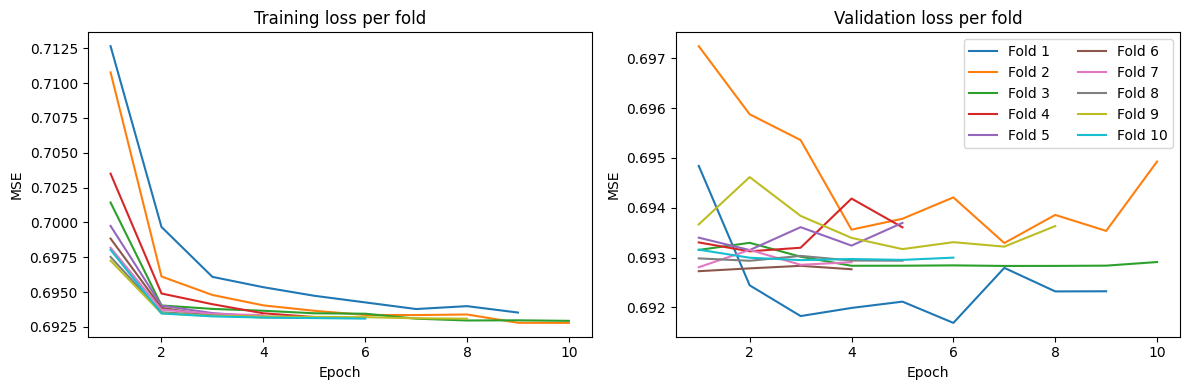

In [25]:
curve_df = pd.concat([pd.DataFrame(h['curve']) for h in best_cv_histories], ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for fold, grp in curve_df.groupby('fold'):
    axes[0].plot(grp['epoch'], grp['train_loss'], label=f'Fold {fold}')
    axes[1].plot(grp['epoch'], grp['val_loss'], label=f'Fold {fold}')

axes[0].set_title('Training loss per fold')
axes[1].set_title('Validation loss per fold')
for ax in axes:
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')
axes[1].legend(ncol=2)
plt.tight_layout()
fig.savefig(ARTIFACT_DIR / 'cv_loss_curves.png')


### Cross-validation diagnostics
Purged and embargoed splits combined with per-symbol scaling can change the optimization dynamics, so we track fold-level losses and Sharpe ratios to quickly spot unstable windows. The plot below summarizes the best metrics from each fold.


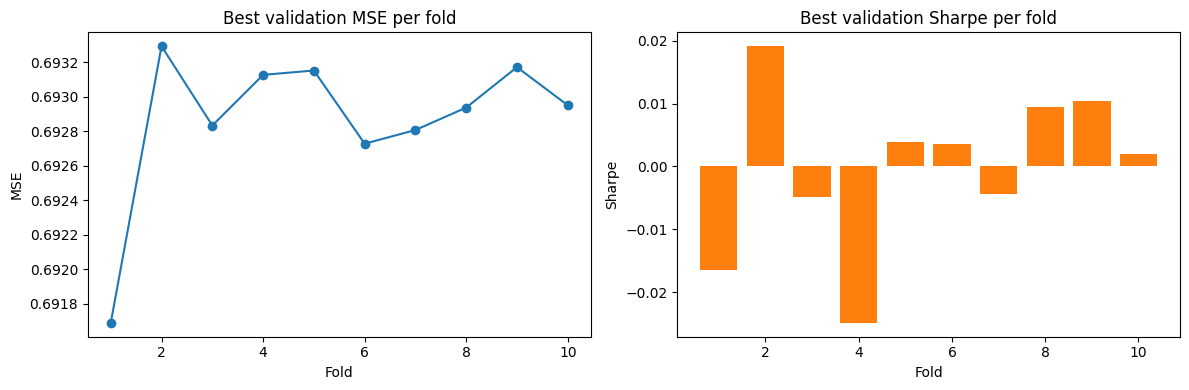

In [26]:
if best_cv_histories:
    cv_df = pd.DataFrame(best_cv_histories)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(cv_df['fold'], cv_df['best_val_mse'], marker='o', color='#1f77b4')
    axes[0].set_title('Best validation MSE per fold')
    axes[0].set_xlabel('Fold')
    axes[0].set_ylabel('MSE')
    axes[1].bar(cv_df['fold'], cv_df['best_val_sharpe'], color='#ff7f0e')
    axes[1].set_title('Best validation Sharpe per fold')
    axes[1].set_xlabel('Fold')
    axes[1].set_ylabel('Sharpe')
    plt.tight_layout()
    fig.savefig(ARTIFACT_DIR / 'cv_best_metrics.png')
else:
    print('best_cv_histories is empty – run the grid search routine first.')


## Final training on full training window

In [27]:
VALID_SPLIT = int(len(train_X_seq) * 0.9)
train_ds = TensorDataset(
    torch.from_numpy(train_X_seq[:VALID_SPLIT]),
    torch.from_numpy(train_symbol_ids[:VALID_SPLIT]),
    torch.from_numpy(train_y_direction[:VALID_SPLIT]),
    torch.from_numpy(train_y_seq[:VALID_SPLIT])
)
val_ds = TensorDataset(
    torch.from_numpy(train_X_seq[VALID_SPLIT:]),
    torch.from_numpy(train_symbol_ids[VALID_SPLIT:]),
    torch.from_numpy(train_y_direction[VALID_SPLIT:]),
    torch.from_numpy(train_y_seq[VALID_SPLIT:])
)

final_batch_size = best_train_kwargs.get('batch_size', BATCH_SIZE)
train_loader = DataLoader(train_ds, batch_size=final_batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=final_batch_size, shuffle=False)

criterion = nn.BCEWithLogitsLoss()
final_model = ReturnTransformer(len(feature_cols), NUM_SYMBOLS, **best_model_kwargs).to(DEVICE)
final_lr = best_train_kwargs.get('lr', 3e-4)
final_weight_decay = best_train_kwargs.get('weight_decay', 5e-4)
final_epochs = best_train_kwargs.get('epochs', 40)
final_patience = best_train_kwargs.get('patience', 5)
optimizer = torch.optim.AdamW(final_model.parameters(), lr=final_lr, weight_decay=final_weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-5
)

best_state = None
best_val = math.inf
best_metrics = None
patience_ctr = 0

log_message(
    f"Final training uses config {best_config_name} | lr={final_lr}, wd={final_weight_decay}, "
    f"batch={final_batch_size}, epochs={final_epochs}"
)

for epoch in range(1, final_epochs + 1):
    train_loss = train_epoch(final_model, train_loader, optimizer, criterion)
    val_loss = eval_epoch(final_model, val_loader, criterion)
    val_metrics = evaluate_loader_metrics(final_model, val_loader)
    log_message(
        f"Final | Epoch {epoch} | train {train_loss:.4f} | val {val_loss:.4f} | "
        f"val_SR {val_metrics['sharpe']:.4f} | acc {val_metrics['accuracy']:.3f} | "
        f"lr {optimizer.param_groups[0]['lr']:.2e}"
    )
    scheduler.step(val_loss)

    improved = False
    if val_loss < best_val - 1e-6:
        improved = True
    elif abs(val_loss - best_val) <= 1e-6 and (
        val_metrics['sharpe'] > (best_metrics['sharpe'] if best_metrics else -math.inf) + 1e-3
    ):
        improved = True

    if improved:
        best_val = val_loss
        best_metrics = val_metrics
        best_state = copy.deepcopy(final_model.state_dict())
        patience_ctr = 0
    else:
        patience_ctr += 1
        if patience_ctr >= final_patience:
            log_message('Early stopping triggered on final model')
            break

if best_state is None:
    raise RuntimeError('Final model never improved; inspect training logs for issues.')

final_model.load_state_dict(best_state)
torch.save(final_model.state_dict(), ARTIFACT_DIR / 'final_model.pt')
log_message(
    f"Best final val Sharpe: {best_metrics['sharpe']:.4f}, accuracy: {best_metrics['accuracy']:.3f}"
)


[2025-11-09T20:54:54.581218+00:00] Final training uses config lightweight_fast | lr=0.0004, wd=0.001, batch=128, epochs=25


[2025-11-09T20:55:18.903442+00:00] Final | Epoch 1 | train 0.6972 | val 0.6933 | val_SR -0.0080 | acc 0.492 | lr 4.00e-04
[2025-11-09T20:55:43.247968+00:00] Final | Epoch 2 | train 0.6935 | val 0.6934 | val_SR -0.0050 | acc 0.490 | lr 4.00e-04
[2025-11-09T20:56:07.576080+00:00] Final | Epoch 3 | train 0.6933 | val 0.6930 | val_SR 0.0050 | acc 0.510 | lr 4.00e-04
[2025-11-09T20:56:32.135627+00:00] Final | Epoch 4 | train 0.6932 | val 0.6930 | val_SR 0.0050 | acc 0.510 | lr 4.00e-04
[2025-11-09T20:56:55.999188+00:00] Final | Epoch 5 | train 0.6932 | val 0.6931 | val_SR 0.0050 | acc 0.510 | lr 4.00e-04
[2025-11-09T20:57:20.699528+00:00] Final | Epoch 6 | train 0.6932 | val 0.6931 | val_SR 0.0050 | acc 0.510 | lr 4.00e-04
[2025-11-09T20:57:20.700905+00:00] Early stopping triggered on final model
[2025-11-09T20:57:20.705736+00:00] Best final val Sharpe: 0.0050, accuracy: 0.510


## Sharpe evaluation

In [28]:
def _predict_with_model(model, X_seq, symbol_ids, actual_returns):
    logits = predict_batches(model, X_seq, symbol_ids)
    probs = 1.0 / (1.0 + np.exp(-logits))
    pred_sign = np.where(probs >= 0.5, 1.0, -1.0)
    pnl_series = pd.Series(pred_sign * actual_returns)
    sharpe = calculate_sharpe(pnl_series)
    return {
        'logits': logits,
        'probs': probs,
        'pred_sign': pred_sign,
        'sharpe': sharpe
    }


def _prepare_prediction_df(pred_dict, meta_dt, symbol_ids, actual_returns):
    return pd.DataFrame({
        'datetime': pd.to_datetime(meta_dt),
        'symbol_id': symbol_ids,
        'symbol': [symbol_list[sid] for sid in symbol_ids],
        'prob_long': pred_dict['probs'],
        'pred_sign': pred_dict['pred_sign'],
        'actual_return': actual_returns
    })

final_model.eval()
train_preds = _predict_with_model(final_model, train_X_seq, train_symbol_ids, train_y_seq_raw)
train_pred_df = _prepare_prediction_df(train_preds, train_meta_dt, train_symbol_ids, train_y_seq_raw)
print(f"Train Sharpe (final model): {train_preds['sharpe']:.6f}")

test_preds = _predict_with_model(final_model, test_X_seq, test_symbol_ids, test_y_seq_raw)
test_pred_df = _prepare_prediction_df(test_preds, test_meta_dt, test_symbol_ids, test_y_seq_raw)
print(f"Test Sharpe  (final model): {test_preds['sharpe']:.6f}")


Train Sharpe (final model): 0.001646
Test Sharpe  (final model): -0.016140


### Hold-out scorecard
Sharpe values below now come from the ensemble of fine-tuned folds (validation split = last 10% of the training block). Large gaps between train/test imply either symbol-level scaling drift or that additional folds should be filtered out.


## Rolling 30-minute backtest (optional heavy cell)

In [29]:
# --- 30min rolling backtest based on final-model predictions ---

ROLLING_STEP_MINUTES = 30
TOP_K = 5

def _select_eval_minutes(unique_minutes, step_minutes):
    selected, last_dt = [], None
    for dt in unique_minutes:
        if last_dt is None or (dt - last_dt) >= np.timedelta64(step_minutes, 'm'):
            selected.append(dt)
            last_dt = dt
    return selected

pred_df = test_pred_df.copy()
pred_df['score'] = pred_df['prob_long'] - 0.5        # 0.5 以上做多，以下做空
pred_df['abs_score'] = pred_df['score'].abs()

evaluation_minutes = _select_eval_minutes(
    np.sort(pred_df['datetime'].unique()), ROLLING_STEP_MINUTES
)

backtest_rows = []
for current_dt in evaluation_minutes:
    minute_df = pred_df[pred_df['datetime'] == current_dt]
    if minute_df.empty:
        continue
    minute_df = minute_df.nlargest(TOP_K, 'abs_score')
    total_abs = minute_df['abs_score'].sum()
    if total_abs == 0:
        continue
    weights = minute_df['score'] / total_abs
    for (i, row), weight in zip(minute_df.iterrows(), weights):
        backtest_rows.append({
            'datetime': current_dt,
            'symbol': row['symbol'],
            'predicted_log_return': row['score'],      # 0.5 正负偏离当作预期收益
            'actual_log_return': row['actual_return'],
            'weight_relative': weight,
            'weight_sign': np.sign(weight)
        })


backtest_df = pd.DataFrame(backtest_rows)
print(backtest_df.head())
print(f"Backtest rows: {len(backtest_df)}")

             datetime symbol  predicted_log_return  actual_log_return  \
0 2025-04-30 13:19:00   AMAT             -0.012890           0.000532   
1 2025-04-30 13:19:00   AMAT             -0.012563           0.000096   
2 2025-04-30 13:49:00   AMAT             -0.013065           0.000792   
3 2025-04-30 13:49:00   AMAT             -0.012978           0.001214   
4 2025-04-30 13:49:00   AMAT             -0.012899           0.000969   

   weight_relative  weight_sign  
0        -0.506426         -1.0  
1        -0.493574         -1.0  
2        -0.204502         -1.0  
3        -0.203140         -1.0  
4        -0.201914         -1.0  
Backtest rows: 3982


In [30]:
backtest_df.head(5)

,datetime,symbol,predicted_log_return,actual_log_return,weight_relative,weight_sign
0,2025-04-30 13:19:00,AMAT,-0.012890,0.000532,-0.506426,-1.0
1,2025-04-30 13:19:00,AMAT,-0.012563,0.000096,-0.493574,-1.0
2,2025-04-30 13:49:00,AMAT,-0.013065,0.000792,-0.204502,-1.0
3,2025-04-30 13:49:00,AMAT,-0.012978,0.001214,-0.203140,-1.0
4,2025-04-30 13:49:00,AMAT,-0.012899,0.000969,-0.201914,-1.0


In [31]:
pnl_series = backtest_df["weight_sign"] * backtest_df["actual_log_return"]
# 或 long-only 策略：backtest_df["weight_relative"] * actual_log_return

raw_sharpe = pnl_series.mean() / pnl_series.std()

# 年化：根据频率设定一年多少个观测点
minutes_per_day = 390        # 美股常规盘
trading_days_per_year = 252
periods_per_year = minutes_per_day * trading_days_per_year

annual_sharpe = raw_sharpe * np.sqrt(periods_per_year)
print(raw_sharpe, annual_sharpe)


-0.0007399805764652059 -0.23198125527395336


In [32]:
# save backtest results
BACKTEST_PATH = Path('transformer_backtest_results.csv')
backtest_df.to_csv(BACKTEST_PATH, index=False)
print(f"Backtest results saved to {BACKTEST_PATH}")

Backtest results saved to transformer_backtest_results.csv


### Strategy visualization
The following chart aggregates the rank-weighted positions into a cumulative log-return curve so we can gauge stability beyond a single Sharpe statistic.


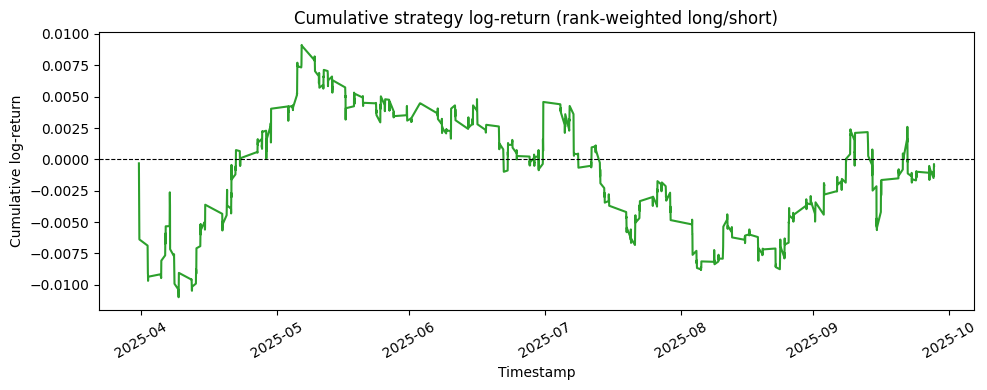

In [33]:

if 'backtest_df' in globals() and not backtest_df.empty:
    pnl_series = backtest_df['weight_relative'] * backtest_df['actual_log_return']
    pnl_by_minute = pnl_series.groupby(backtest_df['datetime']).sum()
    cumulative = pnl_by_minute.cumsum()
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(cumulative.index, cumulative.values, color='#2ca02c')
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.set_title('Cumulative strategy log-return (rank-weighted long/short)')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Cumulative log-return')
    plt.xticks(rotation=30)
    plt.tight_layout()
else:
    print('No backtest dataframe available for visualization.')
